# Image colorization using GANs

## Python and Torch bureaucraty

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage.color import rgb2lab, lab2rgb

import time

import torch
from torch import nn
import torchvision

In [136]:
# To ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [137]:
# use the Metal backend if available (for Apple computers)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
# use CUDA if available (for NVIDIA cards)
elif torch.cuda.is_available():
    device = torch.device('cuda')
# otherwise, use the CPU
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


## Utils functions to use LAB colorspace

In [138]:
def extract_lab_channels(image):
    lab_image = rgb2lab(image)
    l_channel = lab_image[:, :, 0] / 50 - 1
    ab_channels = lab_image[:, :, 1:] / 100
    return l_channel, ab_channels

def colorize_using_ab_channels(original_l_channel, ab_channels):
    l_channel = (original_l_channel + 1) * 50
    ab_channels = ab_channels * 100
    lab_image = np.concatenate([l_channel[:, :, np.newaxis], ab_channels], axis=-1)
    rgb_image = lab2rgb(lab_image)
    return rgb_image

## Dataset creation

In [139]:
SIZE = 32

data_train_imagenette = torchvision.datasets.Imagenette("data", split='train', size="160px")
data_train_imagenette.transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((SIZE, SIZE), PIL.Image.BICUBIC),
    torchvision.transforms.ToTensor()
])

data_train_imagenette = torch.utils.data.Subset(data_train_imagenette, torch.arange(1_000))
len(data_train_imagenette), data_train_imagenette[0][0].shape

(1000, torch.Size([3, 32, 32]))

In [140]:
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0]
        
        # Convert the image to the LAB color space
        img_l, img_ab = extract_lab_channels(img.permute(1, 2, 0).numpy())

        # Returns the L channel (black and white) as the input 
        # and the AB channels (colors) as the target
        img_l, img_ab = torch.tensor(img_l), torch.tensor(img_ab)
        return img_l, img_ab

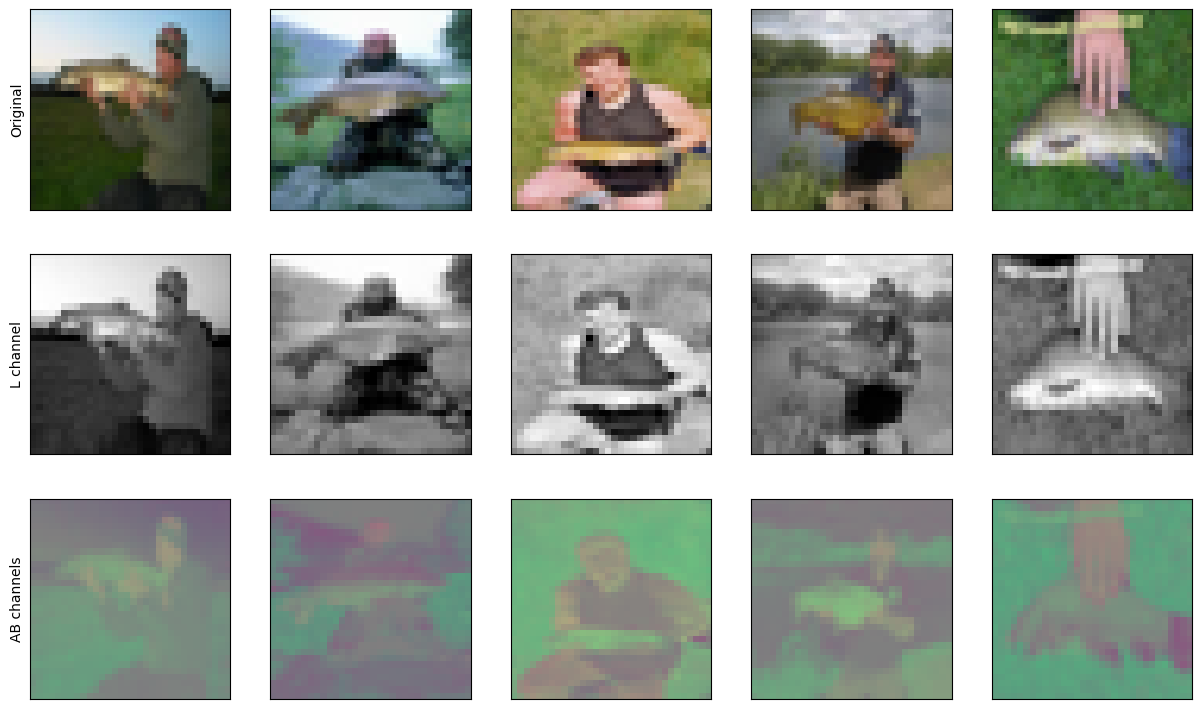

In [141]:
data_train = ColorizationDataset(data_train_imagenette)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    idx = np.random.randint(len(data_train_imagenette))
    original = data_train_imagenette[idx][0]
    source, target = data_train[idx]

    if i == 0:
        axs[0][i].set_ylabel('Original')
        axs[1][i].set_ylabel('L channel')
        axs[2][i].set_ylabel('AB channels')
    
    axs[0][i].imshow(original.permute(1, 2, 0))
    axs[1][i].imshow(source, cmap='gray')
    axs[2][i].imshow((torch.cat((target, torch.zeros((SIZE, SIZE, 1))), dim=-1)+ 1) / 2)

for ax in axs.flat:
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])

## Difference between Grayscale and L channel of LAB colorspace

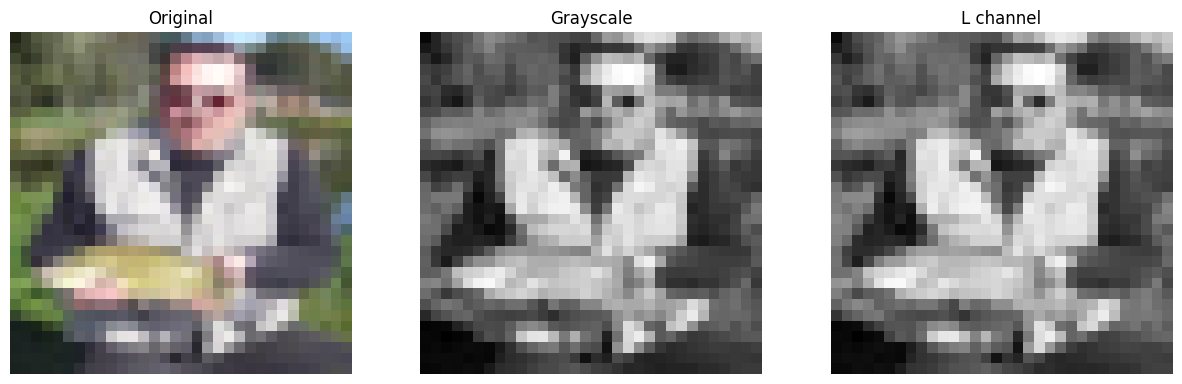

In [142]:
image = data_train_imagenette[np.random.randint(len(data_train_imagenette))][0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Grayscale")
plt.imshow(torchvision.transforms.Grayscale()(image).permute(1, 2, 0), cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("L channel")
plt.imshow(rgb2lab(image.permute(1, 2, 0).numpy())[:, :, 0], cmap='gray')

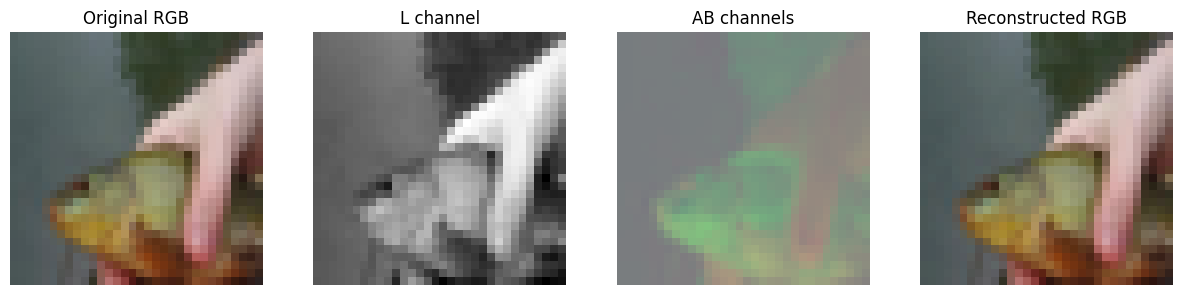

In [143]:
image = data_train_imagenette[np.random.randint(len(data_train_imagenette))][0]
l_channel, ab_channels = extract_lab_channels(image.permute(1, 2, 0).numpy())

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.axis('off')
plt.title("Original RGB")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 4, 2)
plt.axis('off')
plt.title("L channel")
plt.imshow(l_channel, cmap='gray')

plt.subplot(1, 4, 3)
plt.axis('off')
plt.title("AB channels")
plt.imshow((np.concatenate((ab_channels, np.zeros((SIZE, SIZE, 1))), axis=-1) + 1) / 2)

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("Reconstructed RGB")
plt.imshow(colorize_using_ab_channels(l_channel, ab_channels))

## Linear model

In [144]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        self.encoder5 = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))

        # Decoder
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)

# Example usage
model = UNet(in_channels=1, out_channels=2)
print(model)

UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder5): Sequential(
    (0): Conv2

In [145]:
data_train_loader = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)

In [146]:
def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)
  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
      inputs, targets = data
      inputs, targets = inputs.unsqueeze(1).to(device), targets.permute(0, 3, 1, 2).to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"[TRAIN epoch {epoch}]: Loss: {running_loss/len(data_train)}")

In [147]:
train_model(model, data_train_loader, 4)

[TRAIN epoch 0]: Loss: 0.0007156511582434177
[TRAIN epoch 1]: Loss: 0.0006383840553462506
[TRAIN epoch 2]: Loss: 0.0006151586761698127
[TRAIN epoch 3]: Loss: 0.0006028118534013629


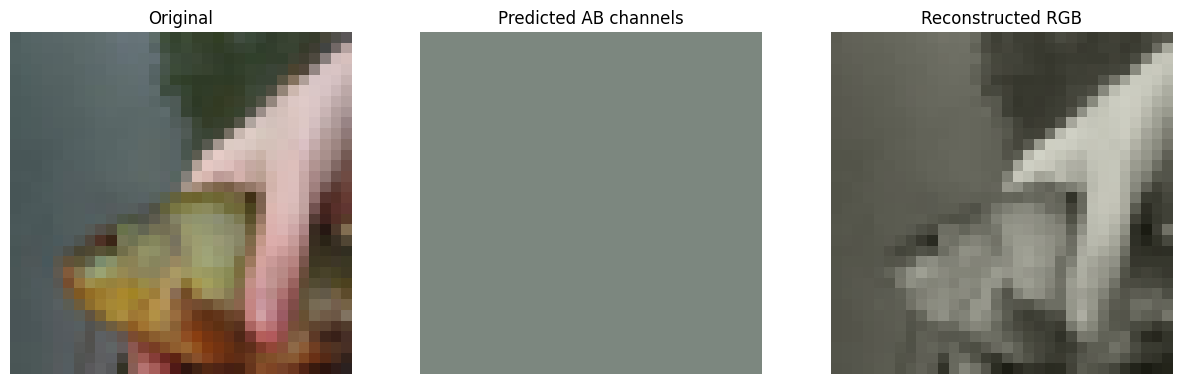

In [150]:
plt.figure(figsize=(15, 5))

predicted_ab_channels = model(torch.tensor(l_channel).unsqueeze(0).unsqueeze(0).to(device)).squeeze(0)

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Predicted AB channels")
plt.imshow((torch.cat((predicted_ab_channels.permute(1, 2, 0), torch.zeros((SIZE, SIZE, 1))), dim=-1).detach().numpy() + 1) / 2)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Reconstructed RGB")
plt.imshow(colorize_using_ab_channels(l_channel, predicted_ab_channels.permute(1, 2, 0).detach().numpy()))